In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import control as ct
import qpsolvers
from qpsolvers import solve_qp
from matplotlib import animation
from scipy import signal
import math
import cvxpy as cp

In [2]:
print(qpsolvers.available_solvers)

['cvxpy', 'ecos', 'osqp', 'quadprog', 'scs']


In [3]:
N=1000
t=np.arange(N)*(1/4000)

In [4]:
x_0=[0.1999]
theta_est_0=0

In [5]:
def f (x):
    return 1.0*x

In [6]:
def g (x): 
    return 1.0

In [7]:
def F (x):
    return x

In [8]:
theta_star=0.5
#v_max=theta_star-theta_est_0
v_max=2.0

In [9]:
phi=lambda x: 1-25*x**2

In [10]:
grad_phi=lambda x: -50*x

In [11]:
grad_phi_theta=lambda x:0

In [12]:
def u_nominal (x):
    return -x

In [13]:
#Hyperparameters

theta=0.07
margin=0.0
#correction_strength=4
#alpha=10

In [14]:
Ts=1/4000
U=np.zeros(N)
S=np.zeros(N)
Dot_X=np.zeros(N)
Dot_theta_est=np.zeros(N)
Gamma=5.0
#last_u=0
#last_u=u_nominal(x_0)
#global_state=0
#global_u=0
#global_timer=0
count=0

In [15]:
def tau(x,theta_est):
    return -grad_phi(x)*F(x)

In [16]:
def lamda_cbf(x,theta_est):
    return theta_est-Gamma*grad_phi_theta(x)

In [17]:
def RaCBF(x,theta_est):
    un=u_nominal(x)
    u=cp.Variable(1)
    P=np.array([[2.0]])
    q=np.array(-2*un)
    G=np.array([-1*grad_phi(x)*g(x)])
    h=np.array(grad_phi(x)*(f(x)+F(x)*lamda_cbf(x,theta_est))+phi(x)-((1/(2*Gamma))*(v_max)**2))
    A=np.array([[0.0]])
    b=np.array([0.0])
    prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(u, P) + q.T @ u),
                 [G @ u <= h,
                  A @ u == b])
    prob.solve()
    if u is None:
        print("solver failed")
    return u.value

In [18]:
def play_dynamics(X,theta_est):
    global count
    #global last_u
    #u=u_nominal(X)
    u=RaCBF(X,theta_est)
    if (count < N):
        U[count]=u
        S[count]=X
        Dot_X[count]=f(X)+np.dot(g(X),u)+np.dot(F(X),theta_star)
        #last_u=u
        Dot_theta_est[count]=Gamma*tau(X,theta_est)
        count=count+1
    return (Dot_X[count-1],Dot_theta_est[count-1])

In [19]:
def dynamics_runner(x_0,theta_est_0,t):
    d=t.shape[0]
    X_0=np.copy(x_0)
    T_0=np.copy(theta_est_0)
    X=x_0
    T=theta_est_0
    X=np.expand_dims(X_0,axis=0)
    T=np.expand_dims(T_0,axis=0)
    #print(np.shape(X))
    dt=t[1]-t[0]
    for i in range(d):
        del_X,del_theta_est=play_dynamics(X[i],T[i])
        dX=dt*del_X
        dT=dt*del_theta_est
        #print(dX)
        X_n=X[i]+dX
        T_n=T[i]+dT
        X=np.append(X,[X_n],axis=0)
        T=np.append(T,[T_n],axis=0)
    return (X,T)

In [20]:
X,T=dynamics_runner(x_0,theta_est_0,t)

In [21]:
phi_RaCBF=np.zeros(N)
for i in range(N):
    phi_RaCBF[i]=phi(S[i])

Text(0.5, 1.0, 'Barrier zeroing function $phi(X)$')

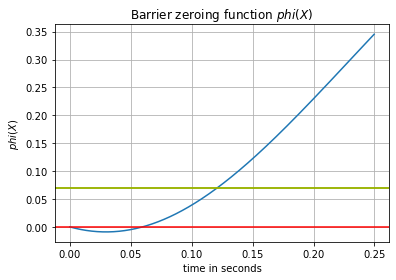

In [22]:
plt.figure()
plt.plot(t[0:N], phi_RaCBF[0:N]); plt.axhline(y = 0, c = 'r');plt.axhline(y=theta,c='g'); plt.axhline(y=theta+margin,c='y'); plt.grid()
plt.xlabel('time in seconds')
plt.ylabel('$phi(X)$')
plt.title('Barrier zeroing function $phi(X)$')

Text(0.5, 1.0, 'State Variable')

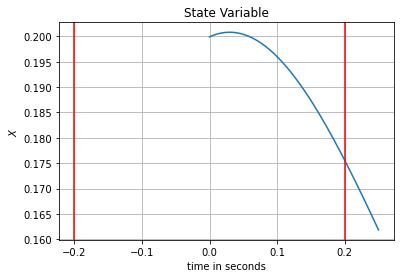

In [23]:
plt.figure()
plt.plot(t[0:N], S[0:N]); plt.axvline(x = 0.2, c = 'r');plt.axvline(x=-0.2,c='r'); plt.grid()
plt.xlabel('time in seconds')
plt.ylabel('$X$')
plt.title('State Variable')

Text(0.5, 1.0, 'Parameter estimation')

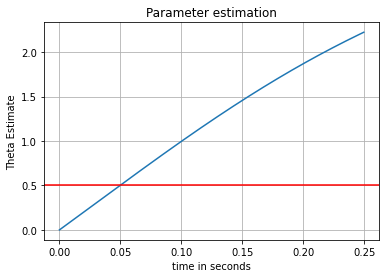

In [24]:
plt.figure()
plt.plot(t[0:N], T[0:N]); plt.axhline(y = 0.5, c = 'r'); plt.grid()
plt.xlabel('time in seconds')
plt.ylabel('Theta Estimate')
plt.title('Parameter estimation')

Text(0.5, 1.0, 'control variable norm dynamics')

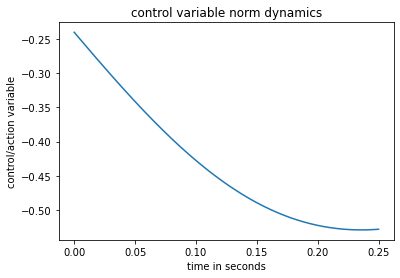

In [25]:
Un=np.zeros(N)
for i in range(N):
    Un[i]=u_nominal(S[i])
plt.figure()
#U_norm=np.linalg.norm(U,axis=0)
plt.plot(t[0:N],U[0:N])
plt.xlabel('time in seconds')
plt.ylabel('control/action variable')
plt.title('control variable norm dynamics')

Text(0.5, 1.0, 'Nominal Controller')

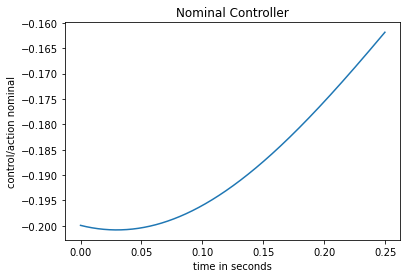

In [26]:
plt.figure()
#U_norm=np.linalg.norm(U,axis=0)
plt.plot(t[0:N],Un[0:N])
plt.xlabel('time in seconds')
plt.ylabel('control/action nominal')
plt.title('Nominal Controller')

In [27]:
np.shape(X)


(1001, 1)

In [28]:
%store phi_RaCBF

Stored 'phi_RaCBF' (ndarray)
